In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [10]:
# 7

image = cv2.imread('box1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

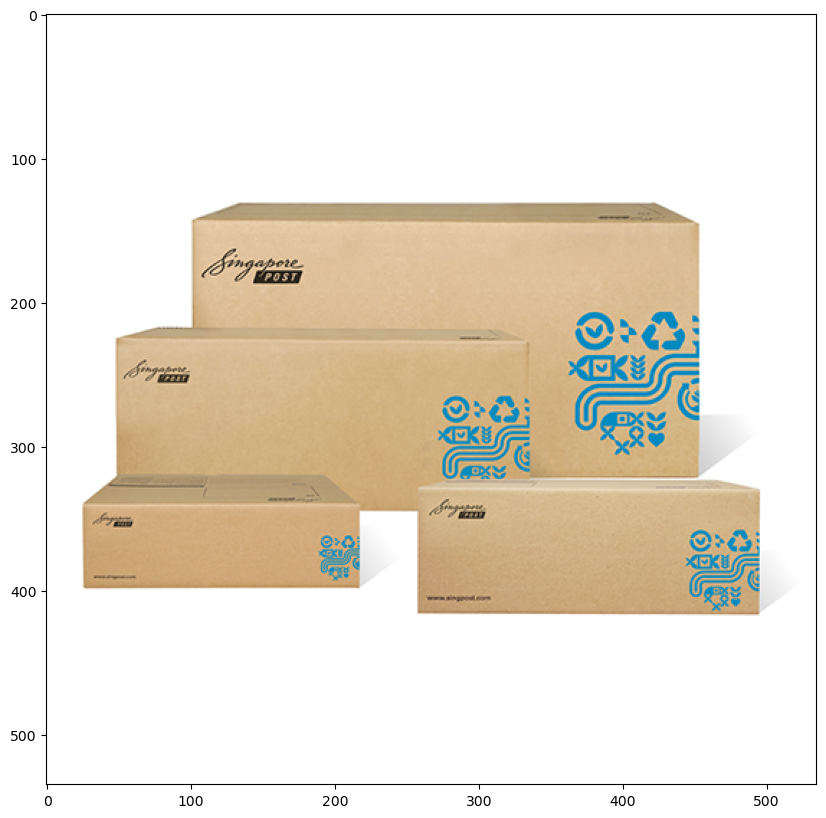

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [18]:
# 10 - model

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [20]:
predictor.set_image(image)

In [22]:
#12

input_point = np.array([[300, 370]])
input_label = np.array([1])

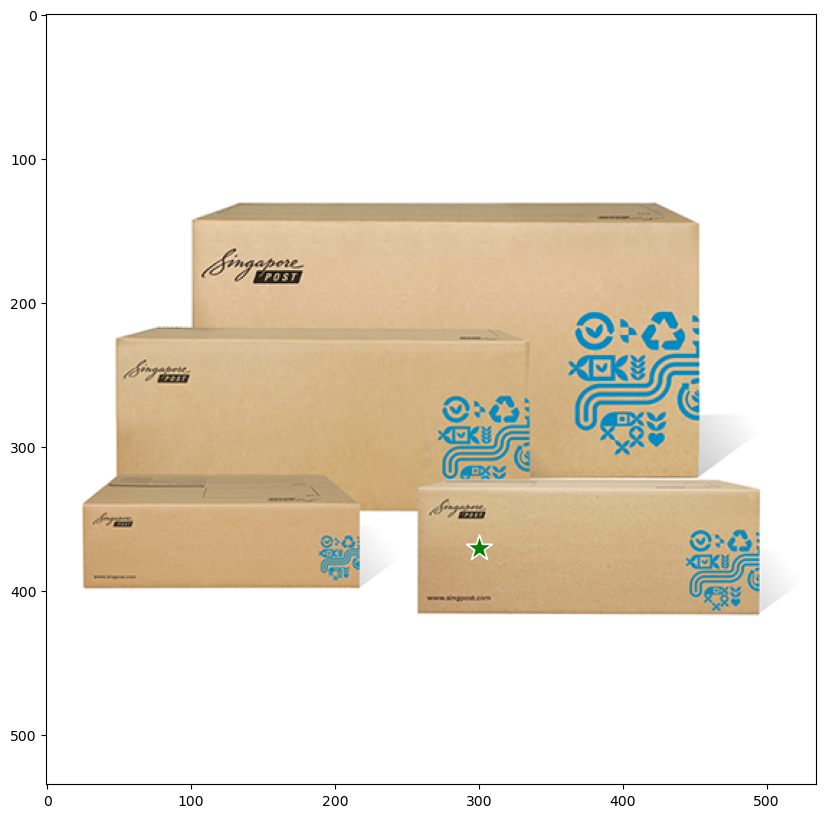

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [24]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [25]:
masks.shape

(3, 535, 535)

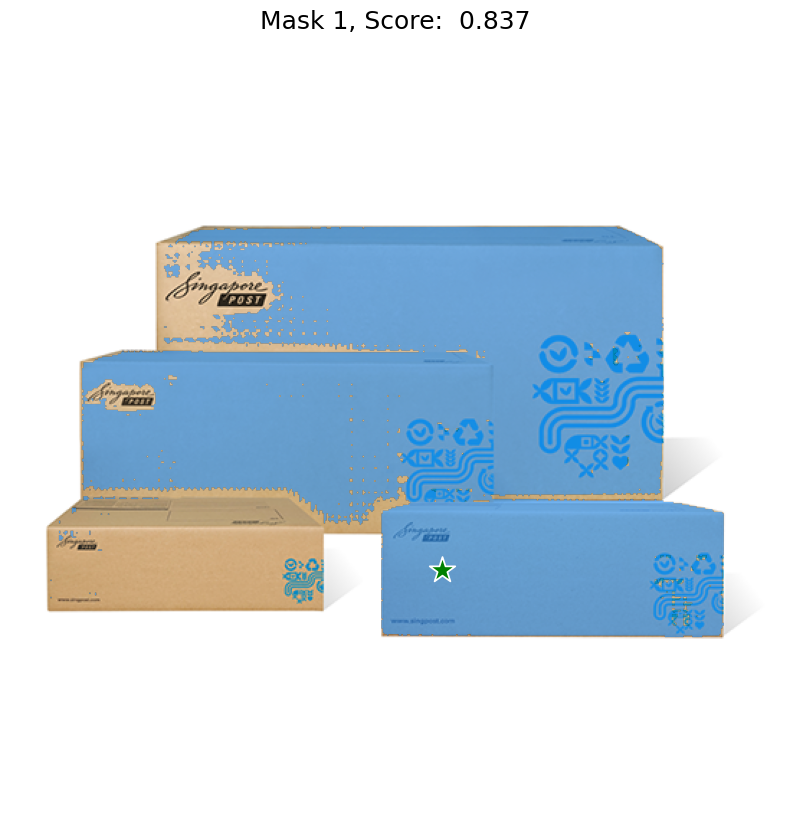

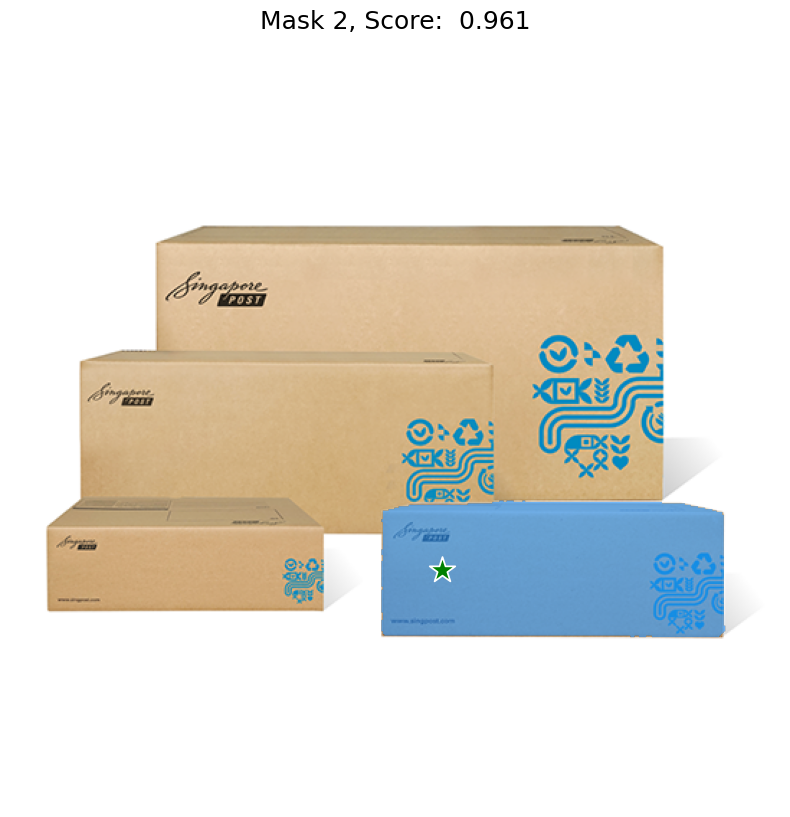

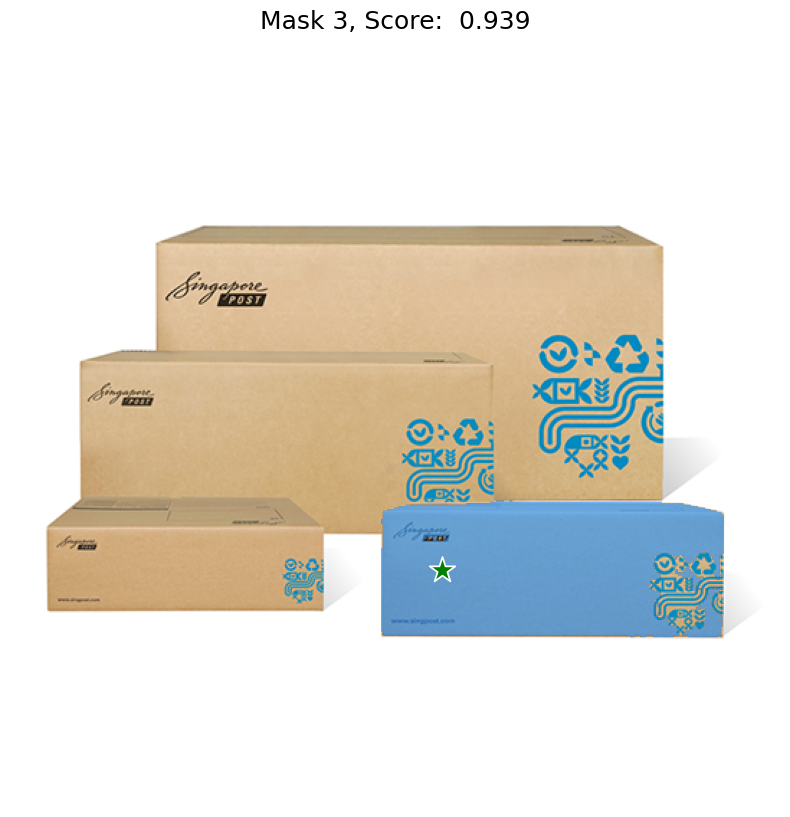

In [26]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score: .3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [27]:
#16

input_point = np.array([[300, 370], [400, 370]])
input_label = np.array([1, 1])

In [28]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

In [29]:
masks.shape

(1, 535, 535)

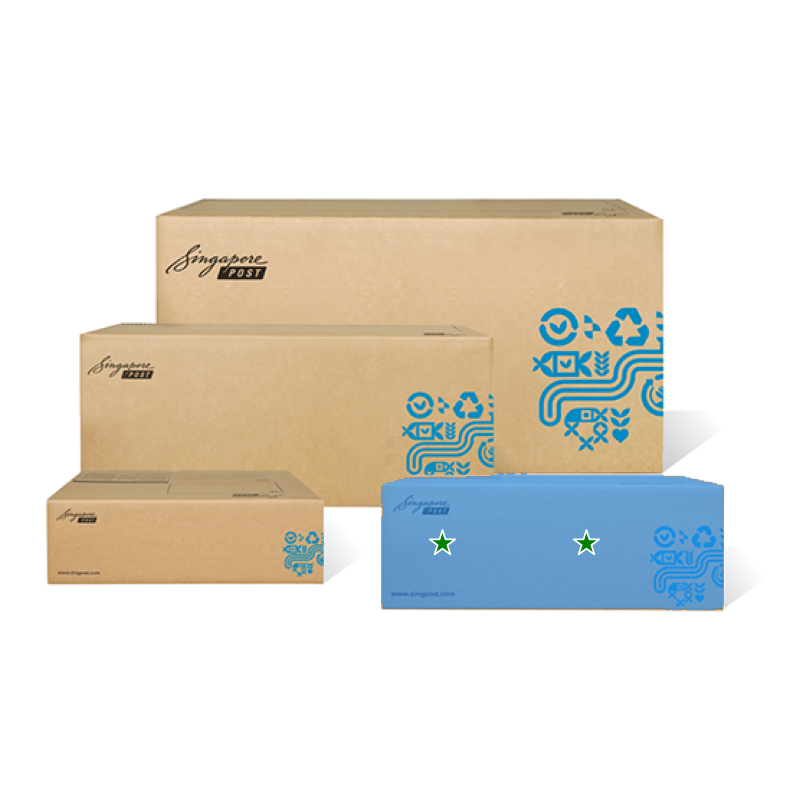

In [30]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [31]:
#19

input_point = np.array([[300, 370], [400, 250]])
input_label = np.array([1, 0])

mask_input = logits[np.argmax(score), :, :]

In [32]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

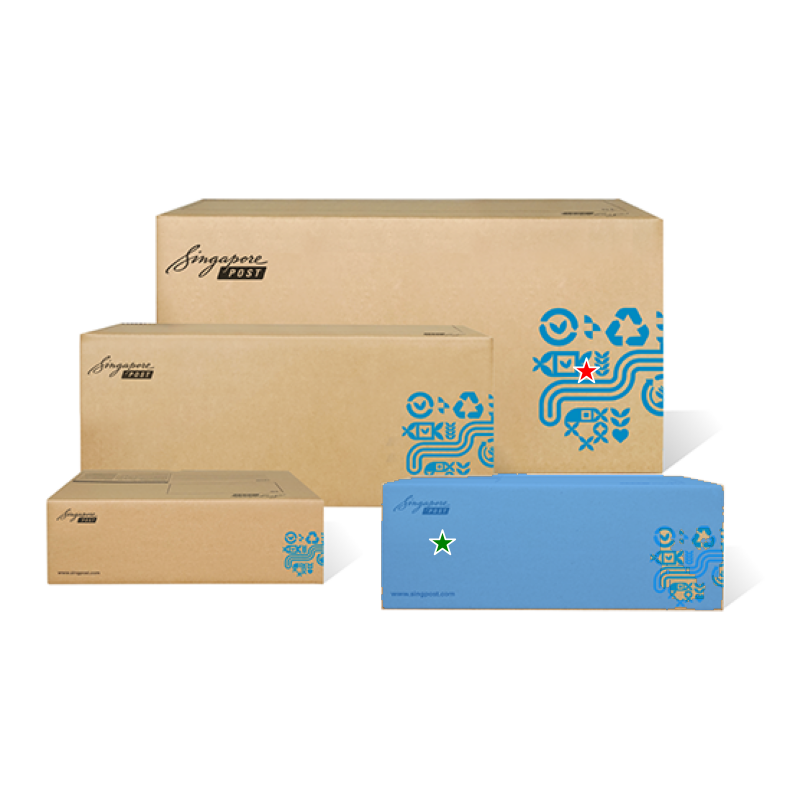

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [43]:
# 21

input_box = np.array([10, 100, 510, 430])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

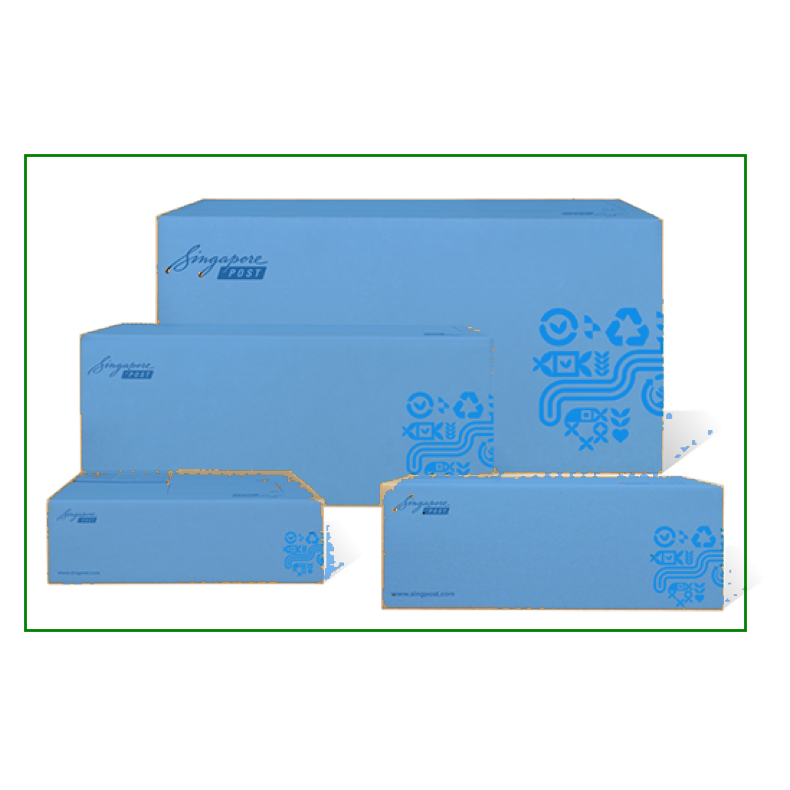

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [65]:
# 22

input_box = np.array([10, 100, 510, 430])
input_point = np.array([[300, 370], [400, 250], [200, 300], [100, 370]])
input_label = np.array([1, 0, 0, 0])

In [66]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

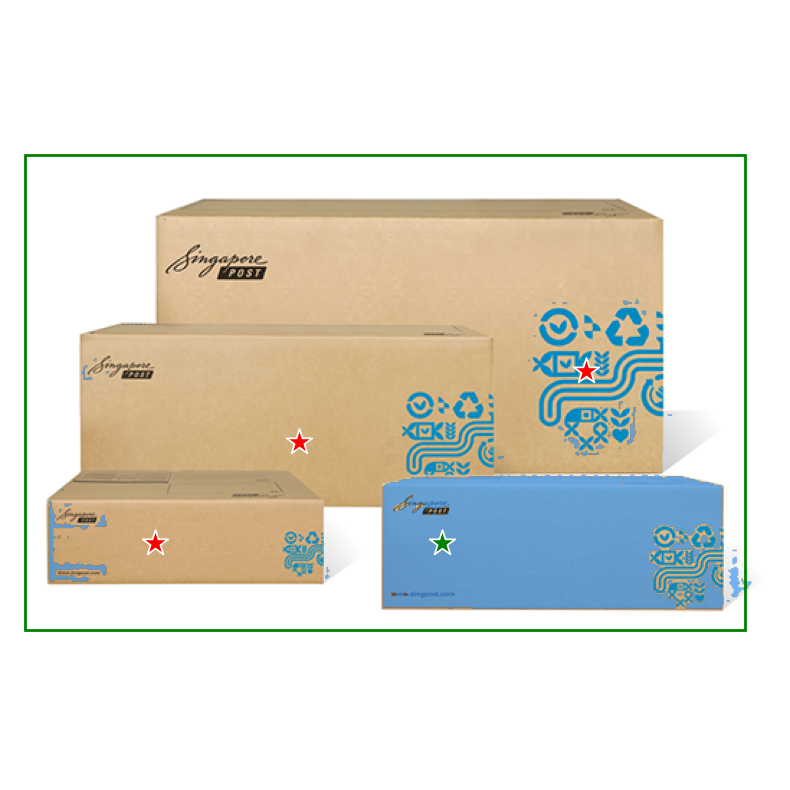

In [67]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [73]:
#24

input_boxes = torch.tensor([
    [10, 100, 510, 430],
    [240, 310, 510, 430]
], device=predictor.device)


In [74]:
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [75]:
masks.shape

torch.Size([2, 1, 535, 535])

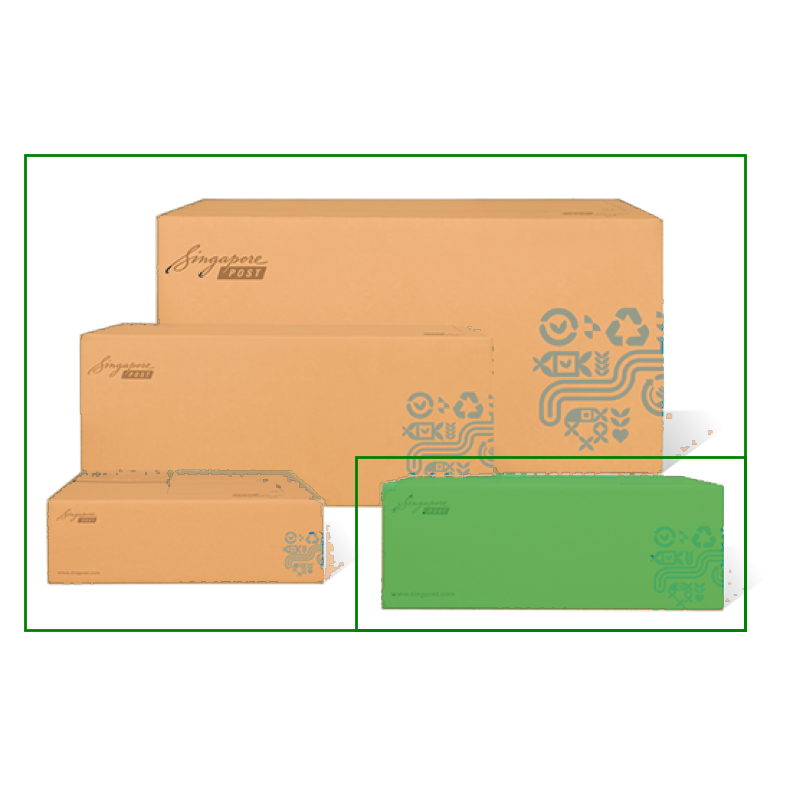

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [ ]:
# capture

import pyrealsense2 as rs
import numpy as np
import cv2

def mouse_callback(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"마우스 클릭 좌표: ({x}, {y})")
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()

# Get device product line for setting a supporting resolution
pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("The demo requires Depth camera with Color sensor")
    exit(0)


config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)

# Start streaming
pipeline.start(config)

try:
    while True:
        frames = pipeline.wait_for_frames()
        color_frame = frames.get_color_frame()
        if not color_frame:
            continue
        color_image = np.asanyarray(color_frame.get_data())
        
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.setMouseCallback("RealSense", mouse_callback)
        cv2.imshow('RealSense', color_image)
        if cv2.waitKey(1) == ord('c'):
            cv2.imwrite('capture.png', color_image)
            print("캡쳐")
finally:
    # Stop streaming
    pipeline.stop()